## Data Exploration with Spark

---

### Import Libraries

In [2]:
# import libraries
import findspark

# Locate the spark installation
findspark.init()

In [40]:
import pandas as pd
import pyspark as ps
from pyspark.sql.functions import col, sum
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

### Initialize Spark

In [4]:
# Initialize a SparkContext
sc = ps.SparkContext(appName="prior_analysis")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/31 14:13:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Connect and import data from HDFS directly into a Spark DataFrame

In [41]:
# Initialize the Session
spark_session = ps.sql.SparkSession(sc)

# Define schema for better manipulation
ratings_schema = StructType([
    StructField("Id", IntegerType(), True),
    StructField("Title", StringType(), True),
    StructField("Price", FloatType(), True),
    StructField("User_id", IntegerType(), True),
    StructField("profileName", StringType(), True),
    StructField("review/helpfulness", StringType(), True),
    StructField("review/score", FloatType(), True),
    StructField("review/time", IntegerType(), True),
    StructField("review/summary", StringType(), True),
    StructField("review/text", StringType(), True)
])

data_schema = StructType([
    StructField("Title", StringType(), True),
    StructField("description", StringType(), True),
    StructField("authors", StringType(), True),
    StructField("image", StringType(), True),
    StructField("previewLink", StringType(), True),
    StructField("publisher", StringType(), True),
    StructField("publishedDate", StringType(), True),
    StructField("infoLink", StringType(), True),
    StructField("categories", StringType(), True),
    StructField("ratingsCount", IntegerType(), True)
])

# Load the data
# name = 'davideligari'
name = 'andreaalberti'
df_data = spark_session.read.csv('hdfs://localhost:9900/user/'+name+'/book_reviews/books_data.csv', header=True, schema=data_schema)
df_ratings = spark_session.read.csv('hdfs://localhost:9900/user/'+name+'/book_reviews/books_rating.csv', header=True, schema=ratings_schema)

### Data Exploration

- Show the first 5 rows of the data
- Investigate the inferred schema of the data
- Discover data dimensionality
- Show some statistics
- Discover null values
- Discover the number of distinct values in each column

In [42]:
# Show the data
print('Data Table: \n')
df_data.show(5)

print('Ratings Table: \n')
df_ratings.show(5)

Data Table: 

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+--------------------+------------+
|               Title|         description|             authors|               image|         previewLink|           publisher| publishedDate|            infoLink|          categories|ratingsCount|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+--------------------+------------+
|Its Only Art If I...|                null|    ['Julie Strain']|http://books.goog...|http://books.goog...|                null|          1996|http://books.goog...|['Comics & Graphi...|        null|
|Dr. Seuss: Americ...|"Philip Nel takes...| like that of Lew...| has changed lang...| giving us new wo...| inspiring artist...|['Philip Nel']|http://books.goog...|http://books.goog...|        nu

In [43]:
#Investigate the schema
print('Data Table Schema: \n')
df_data.printSchema()

print('Ratings Table Schema: \n')
df_ratings.printSchema()

Data Table Schema: 

root
 |-- Title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- image: string (nullable = true)
 |-- previewLink: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- publishedDate: string (nullable = true)
 |-- infoLink: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- ratingsCount: integer (nullable = true)

Ratings Table Schema: 

root
 |-- Id: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: float (nullable = true)
 |-- User_id: integer (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: float (nullable = true)
 |-- review/time: integer (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)



In [44]:
# Check dimensionality
print(f'Data Table Dimensionality: {df_data.count(), len(df_data.columns)}')
print(f'Ratings Table Dimensionality: {df_ratings.count(), len(df_ratings.columns)}')

# Statistical summary
print('Data Table Summary: \n')
df_data.describe().show()

print('Ratings Table Summary: \n')
df_ratings.describe().show()

Data Table Dimensionality: (212404, 10)


Ratings Table Dimensionality: (3000000, 10)
Data Table Summary: 



+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|summary|               Title|         description|             authors|               image|         previewLink|           publisher|       publishedDate|            infoLink|          categories|      ratingsCount|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|  count|              212403|              144047|              181153|              161213|              188349|              139274|              186560|              188103|              171880|               775|
|   mean|   3823.672941176471|  1.4285714285714286|              1578.4|              1184.0|            Infinity|             3

+-------+-------------------+--------------------+------------------+-------+-----------+-------------------+------------------+--------------------+--------------------+--------------------+
|summary|                 Id|               Title|             Price|User_id|profileName| review/helpfulness|      review/score|         review/time|      review/summary|         review/text|
+-------+-------------------+--------------------+------------------+-------+-----------+-------------------+------------------+--------------------+--------------------+--------------------+
|  count|            1280981|             2999792|            480731|      0|    2437800|            2999633|           2981936|             2981912|             2999935|             2999957|
|   mean|8.750887636698718E8|   2012.796651763537|  21.7679511803596|   null|        NaN|3.285048033703448E8|1656.8604219708309|1.1321014125658903E9|            Infinity|  9.95368319174848E8|
| stddev|5.161812590603045E8|  1536.7533

In [29]:
import numpy as np

# Check for number of distinct values for each column in %
n_distinct_list = []

for c in df_data.columns:
    n_distinct = df_data.select(c).distinct().count()
    n_distinct_list.append(n_distinct)

df_data_pandas = pd.DataFrame(index = df_data.columns, columns = ['N. Distinct Values'], data = (np.array((n_distinct_list))/df_data.count())*100)

n_distinct_list = []

for c in df_ratings.columns:
    n_distinct = df_ratings.select(c).distinct().count()
    n_distinct_list.append(n_distinct)

df_ratings_pandas = pd.DataFrame(index = df_ratings.columns, columns = ['N. Distinct Values'], data = (np.array((n_distinct_list))/df_ratings.count())*100)

In [37]:
from pyspark.sql.functions import col, count, when

# Check for missing values
df_data_pandas_tmp = df_data.select([sum(col(c).isNull().cast('int')).alias(c) for c in df_data.columns]).toPandas()
# Add to the pandas summary dataframe
df_data_pandas['N. Missing Values'] = (df_data_pandas_tmp.loc[0, :]/df_data.count()*100).tolist()

# Check for missing values
df_ratings_pandas_tmp = df_ratings.select([sum(col(c).isNull().cast('int')).alias(c) for c in df_ratings.columns]).toPandas()
# Add to the pandas summary dataframe
df_ratings_pandas['N. Missing Values'] = (df_ratings_pandas_tmp.loc[0, :]/df_ratings.count()*100).tolist()

<AxesSubplot: title={'center': 'Ratings Table Summary'}>

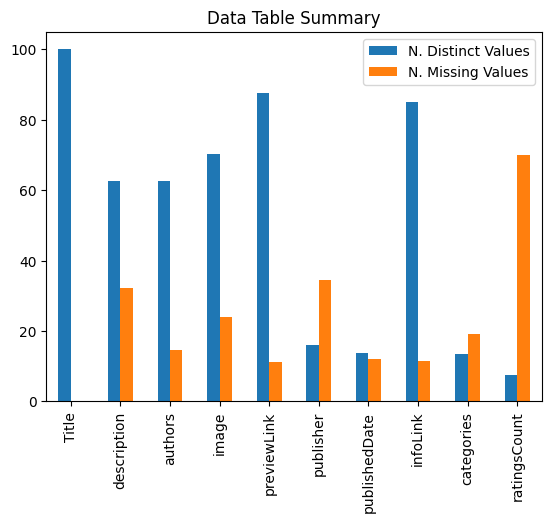

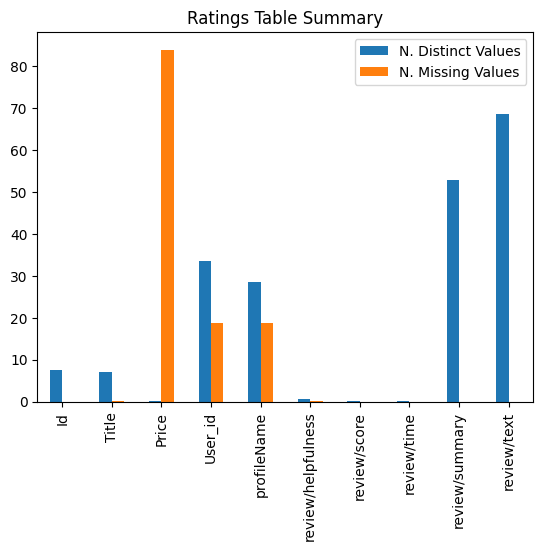

In [38]:
#df_data_pandas.set_index('Column', inplace=True)
df_data_pandas.plot(title='Data Table Summary', kind='bar')

#df_ratings_pandas.set_index('Column', inplace=True)
df_ratings_pandas.plot(title='Ratings Table Summary', kind='bar')

In [1]:
# Stop the SparkContext
sc.stop()

NameError: name 'sc' is not defined